# Project : Evaluation Support Script

This file will contain some supporting functions that will help you evaluate your model. It will show how the validation_grasp_labels.json and validation_object_labels.json can be read in and grasps and object bounding boxes can be drawn on images. It will also show how to convert a grasp in (u, v, width, angle) format into a grasp rectangle prediction.

## Reading in ground-truth labels and visualising on images

In [1]:
import json

#read in test information
with open('validation_prompts.json', 'r') as f:
    val_prompts = json.load(f)
    
#read in gt grasp labels
with open('validation_grasp_labels.json', 'r') as f:
    gt_grasps = json.load(f)

#read in gt object labels
with open('validation_object_labels.json', 'r') as f:
    gt_objects = json.load(f)

In [2]:
len(val_prompts)

620

In [3]:
print(val_prompts['test_1'])

['Graspnet_subset/validation_scenes/scene_0050/rgb/0003.png', 'banana']


**Graspnet_subset/validation_scenes/scene_0050/rgb/0003.png <> Graspnet_subset/validation_scenes/scene_0050/depth/0003.png**

In [4]:
len(gt_grasps['test_1'][0])

4

In [5]:
print(gt_grasps['test_1'][0])

[[393.3008728027344, 153.67750549316406], [457.5617370605469, 130.18824768066406], [468.8244323730469, 161.0001678466797], [404.5635681152344, 184.4894256591797]]


In [6]:
print(gt_objects['test_1'])

['Graspnet_subset/validation_scenes/scene_0050/rgb/0003.png', 'banana', [376, 127, 501, 395]]


In [7]:
_, _, bbox = gt_objects['test_1']
bbox

[376, 127, 501, 395]

In [8]:
test = 'test_1'

file_name, object = val_prompts[test]
_, _, bbox = gt_objects[test]
grasps = gt_grasps[test]

print(f'Testing {file_name} for {object}')
print(f'GT bbox is {bbox}')
print(f'{len(grasps)} possible grasps exist.')

Testing Graspnet_subset/validation_scenes/scene_0050/rgb/0003.png for banana
GT bbox is [376, 127, 501, 395]
2042 possible grasps exist.


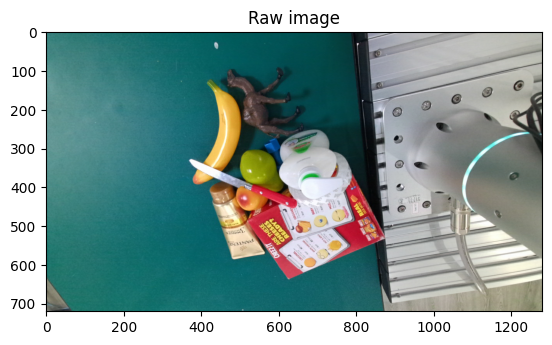

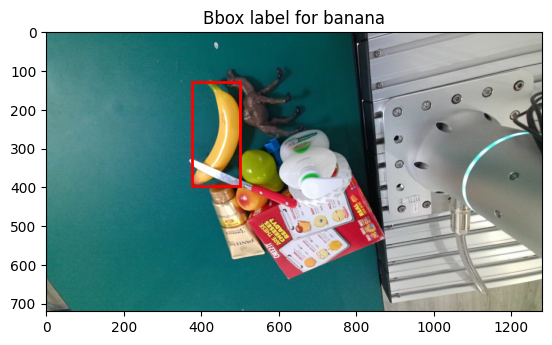

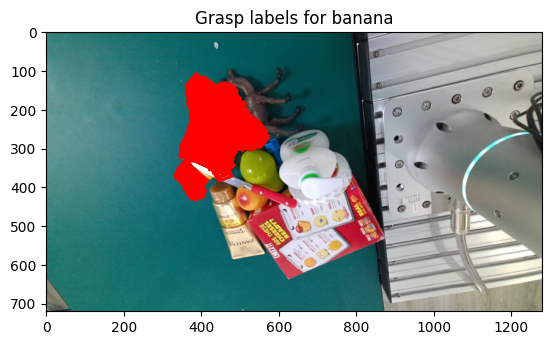

In [9]:
import matplotlib.patches as patches
import cv2
import matplotlib.pyplot as plt

def visualise_image(file_name, polygons = [], caption = ''):
    # This function will visualise an image and a set of provided polygons on the image in red. Image title will be set to caption.
    # Polygons must be described by the points to draw between -- for our application, input the 4 corners of a box.

    #load image and convert to RGB
    im_rgb = cv2.imread(file_name)
    im_rgb = cv2.cvtColor(im_rgb, cv2.COLOR_BGR2RGB)
    
    #create a plot and draw the image
    fig, ax = plt.subplots()
    ax.imshow(im_rgb)

    for p in polygons:
        #draw each polygon in the list with a red edge and linewidth 2
        patch = patches.Polygon(p, closed=True, edgecolor='red', linewidth=2, fill=None)
        ax.add_patch(patch)

    ax.set_title(caption)
        
    plt.show()

#draw the raw image
visualise_image(file_name, caption = 'Raw image')

#draw the bbox on the image. It must be converted from current format [xmin, ymin, xmax, ymax] into a list with all 4 corner coordinates.
polygon_bbox = [[bbox[0], bbox[1]], [bbox[2], bbox[1]], [bbox[2], bbox[3]], [bbox[0], bbox[3]]]
visualise_image(file_name, [polygon_bbox], caption = f'Bbox label for {object}')

#draw the grasps on the image
visualise_image(file_name, grasps, caption = f'Grasp labels for {object}')

## Convert a grasp in (u, v, width, angle) format into a grasp rectangle prediction.

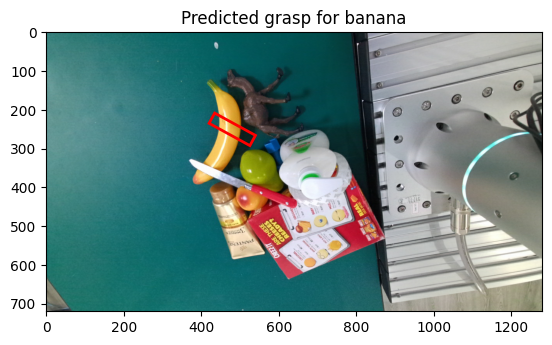

In [10]:
import math 

def get_rotated_rectangle_corners(center_x, center_y, width, angle_rad):
    # Given a grasp prediction in the format required by the assignment, this function will convert it into 
    # 4 rotated rectangle corners that can be drawn onto an image and visualised. Or compared with a GT grasp
    # for performance evaluation.
    
    #height is fixed based on the gripper 
    height = 30
    
    # Extract center coordinates
    cx, cy = center_x, center_y

    # Calculate half dimensions
    half_width = width / 2
    half_height = height / 2
    
    # Calculate the original corner positions relative to the center
    corners = [
        (-half_width, -half_height),  # Bottom-left
        (half_width, -half_height),   # Bottom-right
        (half_width, half_height),    # Top-right
        (-half_width, half_height)    # Top-left
    ]
    
    # Apply rotation and translation to each corner
    rotated_corners = []
    for x, y in corners:
        # Calculate rotated positions
        rotated_x = cx + (x * math.cos(angle_rad)) - (y * math.sin(angle_rad))
        rotated_y = cy + (x * math.sin(angle_rad)) + (y * math.cos(angle_rad))
        rotated_corners.append((rotated_x, rotated_y))
    
    return rotated_corners


u = 480
v = 250
width = 120
angle = 0.5

predicted_grasp_rect = get_rotated_rectangle_corners(u, v, width, angle)
#draw the predicted grasp on the image.
polygon_bbox = [[bbox[0], bbox[1]], [bbox[2], bbox[1]], [bbox[2], bbox[3]], [bbox[0], bbox[3]]]
visualise_image(file_name, [predicted_grasp_rect], caption = f'Predicted grasp for {object}')



---

In [13]:
from torchvision.io.image import read_image
from torchvision.models.detection import fasterrcnn_resnet50_fpn_v2, FasterRCNN_ResNet50_FPN_V2_Weights, fcos_resnet50_fpn, FCOS_ResNet50_FPN_Weights, retinanet_resnet50_fpn_v2, RetinaNet_ResNet50_FPN_V2_Weights
from torchvision.models.detection import maskrcnn_resnet50_fpn_v2, MaskRCNN_ResNet50_FPN_V2_Weights

from torchvision.utils import draw_bounding_boxes, draw_segmentation_masks
from torchvision.transforms.functional import to_pil_image
import torchvision

import torch

from PIL import Image

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

import numpy as np
from colormap import sample_colors
import glob